In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
%matplotlib inline

In [2]:
# CSVファイルを読み込む
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

describeメソッドで中央値や標準偏差を確認する

In [3]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


欠損値の確認をする

In [4]:
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
# 年齢を10歳ごとにカテゴリ分けする
def age_10split(x):
    t = int(x['Age'])
    if (t>=0) and (t<10):
        return 0
    elif (t>=10) and (t<20):
        return 1
    elif (t>=20) and (t<30):
        return 2
    elif (t>=30) and (t<40):
        return 3
    elif (t>=40) and (t<50):
        return 4
    elif (t>=50) and (t<60):
        return 5
    elif (t>=60) and (t<70):
        return 6
    elif (t>=70):
        return 7

# 名前からMr.やMiss.などを抽出する
def name_split(x):
    ret = 'Unknown'
    t = str(x['Name'])
    sex = str(x['Sex'])
    t = t.split()
    for i in t:
        if(sex == 'male'):
            if (i == 'Master.'):
                return i
            else:
                ret = 'Mr.'
        elif(sex == 'female'):
            if(i == 'Mrs.'):
                return i
            else:
                ret = 'Miss.'
        else:
            ret = 'Unknown'
    return ret

# Cabinの先頭アルファベットを取得し、カテゴリとする
def Cabin_split(x):
    t = x['Cabin']
    c = str(t[0])
    if c == 'A' or c == 'a':
        return 0
    elif c == 'B' or c == 'b':
        return 1
    elif c == 'C' or c == 'c':
        return 2 
    elif c == 'D' or c == 'd':
        return 3 
    elif c == 'E' or c == 'e':
        return 4 
    elif c == 'F' or c == 'f':
        return 5
    elif c == 'G' or c == 'g':
        return 6
    elif c == 'H' or c == 'h':
        return 7
    elif c == 'I' or c == 'i':
        return 8
    else:
        return 9

# チケットの重複数でカテゴリ分けする
def ticket_split(x,DF):
    s = str(x['Ticket'])
    n = (len(DF.Ticket.loc[DF.Ticket == s].index.tolist()))
    if n == 1:
        return 1
    elif n == 2:
        return 2
    elif n == 3:
        return 3
    elif n == 4:
        return 4
    elif n == 5:
        return 5
    elif n == 6:
        return 6
    elif n > 6:
        return 7

# Fareの小数点を切り捨てる
def Fare_rounddown(x):
    s = int(x['Fare'])
    return s

# Fareの値ごとにカテゴリ分けする
def Fare_split(x):
    s = int(x['Fare_Rounddown'])
    if (s >= 0) and (s < 10):
        return 0
    elif (s >= 10) and (s < 20):
        return 1
    elif (s >= 20) and (s < 30):
        return 2
    elif (s >= 30) and (s < 40):
        return 3
    elif (s >= 40) and (s < 50):
        return 4
    elif (s >= 50) and (s < 60):
        return 5
    elif (s >= 60) and (s < 70):
        return 6
    elif (s >= 70) and (s < 80):
        return 7
    elif (s >= 80) and (s < 90):
        return 8
    elif (s >= 90) and (s < 100):
        return 9
    elif (s >= 100) and (s < 110):
        return 10
    elif (s >= 110) and (s < 120):
        return 11
    elif (s >= 120) and (s < 130):
        return 12
    elif (s >= 130):
        return 13
    
# SibSpとParchの和を返す
def concat_SibSp_Parch(x):
    t1 = int(x['SibSp'])
    t2 = int(x['Parch'])
    if (t1+t2+1 > 7):
        return 7
    return t1+t2+1

# SibParchが1のとき、つまり一人で乗客したかどうかを判定する
def is_Alone(x):
    t = int(x['SibParch'])
    if t == 1:
        return 1
    return 0

# Cabinが不明でないかどうかの判定をする
def has_Cabin(x):
    t = str(x['Cabin'])
    if t == 'Unknown':
        return 0
    else:
        return 1

In [6]:
train_df = train_df.loc[:,['PassengerId','Survived','Pclass','Name','Sex','Age','SibSp','Parch','Ticket','Fare','Cabin','Embarked']]

train_df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


生存者が何名か確認する

In [7]:
train_df['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

Fareが高い乗客ほど生存率が高いという仮説を立てる     
昇順で１００人ずつに絞って生存者が何人いるか確認する。      

In [8]:
for i in range(0,9):
    n = train_df.sort_values(by='Fare')[i*100:i*100+100].Survived.sum()
    print(str(i*100)+" ~ "+str(i*100+100)+" "+str(n))

0 ~ 100 15
100 ~ 200 28
200 ~ 300 17
300 ~ 400 36
400 ~ 500 37
500 ~ 600 47
600 ~ 700 44
700 ~ 800 49
800 ~ 900 69


In [9]:
# 昇順でソートする
train_df.sort_values(by='Fare').head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S
633,634,0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0,NaN,S
277,278,0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0,NaN,S


運賃が0円の客がいる、招待された客かもしれない      
招待された客の中にはPclassが1の客もいる。０円の客の集合では25歳の男性のみが生存者     
Fareの小数点以下を切り捨てて、どれくらいの運賃で乗っている人が多いか確認する。      

In [10]:
train_df['Fare_Rounddown'] = train_df.apply(lambda x: Fare_rounddown(x), axis=1)

In [11]:
train_df['Fare_Rounddown'].value_counts()

7      213
8       70
26      57
13      50
10      28
15      27
9       25
14      21
27      17
30      15
0       15
31      14
39      13
12      13
16      12
21      11
6       11
24      10
29      10
52      10
20       9
69       9
56       9
11       9
25       8
18       8
23       8
19       8
79       7
46       6
      ... 
247      2
133      2
146      2
262      2
164      2
91       2
28       2
89       2
66       2
65       2
108      2
82       2
50       2
80       2
93       2
37       2
36       2
32       2
106      2
221      1
4        1
81       1
5        1
63       1
75       1
59       1
47       1
42       1
40       1
38       1
Name: Fare_Rounddown, Length: 91, dtype: int64

７ドル台で乗っている客が多い     
次は10ドルごとに区切った時の乗客の数をみる     

In [12]:
train_df['Fare_Rounddown_Split'] = train_df.apply(lambda x: Fare_split(x), axis=1)

In [13]:
train_df['Fare_Rounddown_Split'].value_counts()

0     336
1     179
2     136
3      64
5      39
13     38
7      29
6      17
8      15
4      15
9       8
11      7
12      4
10      4
Name: Fare_Rounddown_Split, dtype: int64

0 <= x < 10ドルの客が一番多い    
120ドル以上の客もそこそこいる     
区切った時の生存者が何人いるか割合をみる     

In [14]:
for i in range(0,14):
    t = train_df[train_df['Fare_Rounddown_Split'] == i]
    n = t[t['Survived'] == 1].Survived.sum()
    print(str(i)+" : "+str(n/len(t)))

0 : 0.199404761905
1 : 0.424581005587
2 : 0.426470588235
3 : 0.4375
4 : 0.266666666667
5 : 0.692307692308
6 : 0.352941176471
7 : 0.586206896552
8 : 0.866666666667
9 : 0.875
10 : 0.5
11 : 0.714285714286
12 : 1.0
13 : 0.736842105263


Fareの値が大きい人たちほど生存率が高いとみてよさそう     

次は女性の方が優先的に救助されるんじゃないか?という仮説を立てて調べてみる。     

In [15]:
survived_by_sex = train_df.groupby(['Sex','Survived']).size().reset_index(name='count')
survived_by_sex

,Sex,Survived,count
0,female,0,81
1,female,1,233
2,male,0,468
3,male,1,109


In [16]:
ave_survived_by_sex = pd.pivot_table(survived_by_sex, index=['Sex'], columns='Survived', values='count').reset_index()
ave_survived_by_sex['ave_Survived'] = ave_survived_by_sex[1] / (ave_survived_by_sex[1] + ave_survived_by_sex[0])
ave_survived_by_sex

Survived,Sex,0,1,ave_Survived
0,female,81,233,0.742038
1,male,468,109,0.188908


女性のが生存率が高いのは間違いない。      
次は年齢が若い人、子供とかの方が救助が優先されるのではないかと仮説を立ててみる。     
Ageが不明な人の行を除く     
dropnaにて列を指定した行の値がNaNのものを除去することができる

In [17]:
train_df2 = train_df.dropna(subset=['Age']).copy()
len(train_df2)

714

In [18]:
train_df2['Age'].value_counts()

24.00    30
22.00    27
18.00    26
19.00    25
30.00    25
28.00    25
21.00    24
25.00    23
36.00    22
29.00    20
32.00    18
27.00    18
35.00    18
26.00    18
16.00    17
31.00    17
20.00    15
33.00    15
23.00    15
34.00    15
39.00    14
17.00    13
42.00    13
40.00    13
45.00    12
38.00    11
50.00    10
2.00     10
4.00     10
47.00     9
         ..
71.00     2
59.00     2
63.00     2
0.83      2
30.50     2
70.00     2
57.00     2
0.75      2
13.00     2
10.00     2
64.00     2
40.50     2
32.50     2
45.50     2
20.50     1
24.50     1
0.67      1
14.50     1
0.92      1
74.00     1
34.50     1
80.00     1
12.00     1
36.50     1
53.00     1
55.50     1
70.50     1
66.00     1
23.50     1
0.42      1
Name: Age, Length: 88, dtype: int64

20~30代が多そうだ。     
年齢を10歳ごとに分割した新たな属性を作成する。     

In [19]:
train_df2['By_Age_Class'] = train_df2.apply(lambda x: age_10split(x), axis=1)

In [20]:
v = train_df2['By_Age_Class'].value_counts()
for i in range(0,8):
    if(i == 7):
        print(" 70~  : " + str(v[i]))
    else:
        print(str(i*10) +" ~ "+str(i*10+9) + " : " + str(v[i]))

0 ~ 9 : 62
10 ~ 19 : 102
20 ~ 29 : 220
30 ~ 39 : 167
40 ~ 49 : 89
50 ~ 59 : 48
60 ~ 69 : 19
 70~  : 7


In [21]:
survived_by_age = train_df2.groupby(['By_Age_Class','Survived']).size().reset_index(name='count')
survived_by_age

,By_Age_Class,Survived,count
0,0,0,24
1,0,1,38
2,1,0,61
3,1,1,41
4,2,0,143
5,2,1,77
6,3,0,94
7,3,1,73
8,4,0,55
9,4,1,34


In [22]:
# 年齢を10歳ごとに区切った生存者の割合を確認する
ave_survived_by_age = pd.pivot_table(survived_by_age, index=['By_Age_Class'], columns='Survived', values='count').reset_index()
ave_survived_by_age['ave_Survived'] = ave_survived_by_age[1] / (ave_survived_by_age[1] + ave_survived_by_age[0])
ave_survived_by_age

Survived,By_Age_Class,0,1,ave_Survived
0,0,24,38,0.612903
1,1,61,41,0.401961
2,2,143,77,0.350000
3,3,94,73,0.437126
4,4,55,34,0.382022
5,5,28,20,0.416667
6,6,13,6,0.315789
7,7,6,1,0.142857


せっかくなので割合をヒストグラムで表示してみる

In [23]:
ave_survived_count = pd.DataFrame()
ave_survived_count['Survived'] = ave_survived_by_age[0]
ave_survived_count['Died'] = ave_survived_by_age[1]

In [24]:
ave_survived_count

,Survived,Died
0,24,38
1,61,41
2,143,77
3,94,73
4,55,34
5,28,20
6,13,6
7,6,1


In [25]:
# 割合で正規化
ave_survived_count_subset = ave_survived_count.div(ave_survived_count.sum(1),axis=0)
ave_survived_count_subset

,Survived,Died
0,0.387097,0.612903
1,0.598039,0.401961
2,0.650000,0.350000
3,0.562874,0.437126
4,0.617978,0.382022
5,0.583333,0.416667
6,0.684211,0.315789
7,0.857143,0.142857


インデックス(行)がこのままではわかりにくいので年齢の区切りに変更する     
インデックス、カラムの名前の変更はrenameで変更できる     

In [26]:
ave_survived_count_subset = ave_survived_count_subset.rename(index={0:'0~9',1:'10~19',2:'20~29',3:'30~39',4:'40~49',5:'50~59',6:'60~69',7:'70~'})

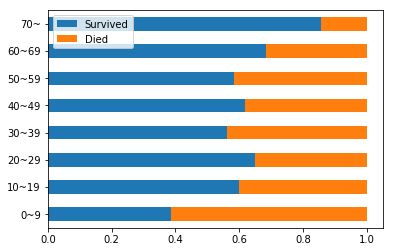

In [27]:
ave_survived_count_subset.plot(kind='barh',stacked=True)

0~10歳の年齢の乗客は生存率が他の年齢に比べて高い。     
他の年齢では生存率はあまり変わらないと見える。      
次はPclass別で優遇は違うから生存率も違うのではないかと仮説を立てる。      

In [28]:
# Pclassのカテゴリごとの合計
train_df['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

Pclassは一番下のランクである3が多い。      

In [29]:
survived_by_pclass = train_df.groupby(['Pclass','Survived']).size().reset_index(name='count')
survived_by_pclass

,Pclass,Survived,count
0,1,0,80
1,1,1,136
2,2,0,97
3,2,1,87
4,3,0,372
5,3,1,119


In [30]:
# Pclassのカテゴリごとの生存者の割合
ave_survived_by_pclass = pd.pivot_table(survived_by_pclass, index=['Pclass'], columns='Survived', values='count').reset_index()
ave_survived_by_pclass['ave_Survived'] = ave_survived_by_pclass[1] / (ave_survived_by_pclass[1] + ave_survived_by_pclass[0])
ave_survived_by_pclass

Survived,Pclass,0,1,ave_Survived
0,1,80,136,0.629630
1,2,97,87,0.472826
2,3,372,119,0.242363


Plcassは1の人が生存率が高い。3の乗客は逆に低い。      
年齢別でPclassのランクに偏りがあるか確認する。      

In [31]:
for i in range(0,8):
    t = train_df2[train_df2['By_Age_Class'] == i]
    print(str(i*10) +" ~ "+str(i*10+10))
    n = t[t['Pclass'] == 1].Pclass.sum()
    print(" Pclass1 : " + str(n/len(t)))
    n = t[t['Pclass'] == 2].Pclass.sum()
    print(" Pclass2 : " + str((n/2)/len(t)))
    n = t[t['Pclass'] == 3].Pclass.sum()
    print(" Pclass3 : " + str((n/3)/len(t)))

0 ~ 10
 Pclass1 : 0.0483870967742
 Pclass2 : 0.274193548387
 Pclass3 : 0.677419354839
10 ~ 20
 Pclass1 : 0.176470588235
 Pclass2 : 0.176470588235
 Pclass3 : 0.647058823529
20 ~ 30
 Pclass1 : 0.154545454545
 Pclass2 : 0.240909090909
 Pclass3 : 0.604545454545
30 ~ 40
 Pclass1 : 0.299401197605
 Pclass2 : 0.287425149701
 Pclass3 : 0.413173652695
40 ~ 50
 Pclass1 : 0.415730337079
 Pclass2 : 0.202247191011
 Pclass3 : 0.38202247191
50 ~ 60
 Pclass1 : 0.5625
 Pclass2 : 0.3125
 Pclass3 : 0.125
60 ~ 70
 Pclass1 : 0.684210526316
 Pclass2 : 0.157894736842
 Pclass3 : 0.157894736842
70 ~ 80
 Pclass1 : 0.571428571429
 Pclass2 : 0.142857142857
 Pclass3 : 0.285714285714


0~10,10~20代の乗客はPclass3が多く、30~80代はPclass1が若干多いとわかる。      

SibSp,Parchによって生存率が変わるか確かめる     
SibSpとParchを結合する。      

In [32]:
train_df['SibParch'] = train_df.apply(lambda x: concat_SibSp_Parch(x), axis=1)

In [33]:
train_df['SibParch'].value_counts()

1    537
2    161
3    102
4     29
7     25
6     22
5     15
Name: SibParch, dtype: int64

SibParch = 1 つまり一人で乗客している人が多い。    
SibParch = 2以上は家族連れだとわかる。      

In [34]:
survived_by_sibparch = train_df.groupby(['SibParch','Survived']).size().reset_index(name='count')
survived_by_sibparch

,SibParch,Survived,count
0,1,0,374
1,1,1,163
2,2,0,72
3,2,1,89
4,3,0,43
5,3,1,59
6,4,0,8
7,4,1,21
8,5,0,12
9,5,1,3


In [35]:
# SibParchでの生存者の割合
ave_survived_by_sibparch = pd.pivot_table(survived_by_sibparch, index=['SibParch'], columns='Survived', values='count').reset_index()
ave_survived_by_sibparch['ave_Survived'] = ave_survived_by_sibparch[1] / (ave_survived_by_sibparch[1] + ave_survived_by_sibparch[0])
ave_survived_by_sibparch

Survived,SibParch,0,1,ave_Survived
0,1,374,163,0.303538
1,2,72,89,0.552795
2,3,43,59,0.578431
3,4,8,21,0.724138
4,5,12,3,0.200000
5,6,19,3,0.136364
6,7,21,4,0.160000


SibParchが4の乗客が生存率が一番高い。      
逆に5~7は生存率が低い。      

Embark別で生存率に変化があるか確認する。     
まずはNaNを出現率が高いものに置き換えて、文字列を数値に変換する    
欠損値を別の値で置き換えるにはfillna(置き換えたい値)で置き換えることができる

In [36]:
train_df['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [37]:
# Sが一番多いのでSで置換する
train_df['Embarked'] = train_df[['Embarked']].fillna('S')

In [38]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

train_df['onehot_Embarked'] = train_df[['Embarked']].apply(le.fit_transform)
train_df['onehot_Embarked'].value_counts()

2    646
0    168
1     77
Name: onehot_Embarked, dtype: int64

0 = C      
1 = Q      
2 = S      

In [39]:
survived_by_embarked = train_df.groupby(['onehot_Embarked','Survived']).size().reset_index(name='count')
survived_by_embarked

,onehot_Embarked,Survived,count
0,0,0,75
1,0,1,93
2,1,0,47
3,1,1,30
4,2,0,427
5,2,1,219


In [40]:
ave_survived_by_embarked = pd.pivot_table(survived_by_embarked, index=['onehot_Embarked'], columns='Survived', values='count').reset_index()
ave_survived_by_embarked['ave_Survived'] = ave_survived_by_embarked[1] / (ave_survived_by_embarked[1] + ave_survived_by_embarked[0])
ave_survived_by_embarked

Survived,onehot_Embarked,0,1,ave_Survived
0,0,75,93,0.553571
1,1,47,30,0.389610
2,2,427,219,0.339009


どれも飛び抜けて生存率が高いというのはなさそう      
CabinはNaNの乗客が多いが、Cabinの値の有無で生存率が変化するか確認する     
CabinのNaNをUnknownという文字列で変換する      

In [41]:
train_df['Cabin'] = train_df[['Cabin']].fillna('Unknown')

In [42]:
train_df['isCabin'] = train_df.apply(lambda x: has_Cabin(x), axis=1)

In [43]:
train_df['isCabin'].value_counts()

0    687
1    204
Name: isCabin, dtype: int64

In [44]:
survived_by_iscabin = train_df.groupby(['isCabin','Survived']).size().reset_index(name='count')
survived_by_iscabin

,isCabin,Survived,count
0,0,0,481
1,0,1,206
2,1,0,68
3,1,1,136


In [45]:
ave_survived_by_iscabin = pd.pivot_table(survived_by_iscabin, index=['isCabin'], columns='Survived', values='count').reset_index()
ave_survived_by_iscabin['ave_Survived'] = ave_survived_by_iscabin[1] / (ave_survived_by_iscabin[1] + ave_survived_by_iscabin[0])
ave_survived_by_iscabin

Survived,isCabin,0,1,ave_Survived
0,0,481,206,0.299854
1,1,68,136,0.666667


Cabinの値を持っている乗客のが生存率は高い      
Ticketは個人客は重複のない一枚のチケットを持っていることが多い。家族連れは同じチケットを複数持っている。        
チケットの重複数から生存率に変化があるか確認する。       

In [46]:
train_df['Ticket_num'] = train_df.apply(lambda x: ticket_split(x,train_df), axis=1)

In [47]:
train_df['Ticket_num'].value_counts()

1    547
2    188
3     63
4     44
7     21
6     18
5     10
Name: Ticket_num, dtype: int64

In [48]:
survived_by_ticket = train_df.groupby(['Ticket_num','Survived']).size().reset_index(name='count')
survived_by_ticket

,Ticket_num,Survived,count
0,1,0,384
1,1,1,163
2,2,0,80
3,2,1,108
4,3,0,19
5,3,1,44
6,4,0,22
7,4,1,22
8,5,0,10
9,6,0,18


In [49]:
# チケットの重複数での生存者の割合
ave_survived_by_ticket = pd.pivot_table(survived_by_ticket, index=['Ticket_num'], columns='Survived', values='count').reset_index()
ave_survived_by_ticket['ave_Survived'] = ave_survived_by_ticket[1] / (ave_survived_by_ticket[1] + ave_survived_by_ticket[0])
ave_survived_by_ticket

Survived,Ticket_num,0,1,ave_Survived
0,1,384.0,163.0,0.297989
1,2,80.0,108.0,0.574468
2,3,19.0,44.0,0.698413
3,4,22.0,22.0,0.500000
4,5,10.0,NaN,NaN
5,6,18.0,NaN,NaN
6,7,16.0,5.0,0.238095


チケットの重複が2~3枚の乗客が生存率が高い。      
名前にはMr.やMaster,Missなどが入っている。       
名前の属性からこれらを抽出して特徴として扱えるか確認する。      
title_nameという新たな属性に値を格納する

In [50]:
train_df['title_name'] = train_df.apply(lambda x: name_split(x), axis=1)

In [51]:
train_df['title_name'].value_counts()

Mr.        537
Miss.      189
Mrs.       125
Master.     40
Name: title_name, dtype: int64

男性はMr.、女性はMiss.のが多い。      

In [52]:
survived_by_title = train_df.groupby(['title_name','Survived']).size().reset_index(name='count')
survived_by_title

,title_name,Survived,count
0,Master.,0,17
1,Master.,1,23
2,Miss.,0,55
3,Miss.,1,134
4,Mr.,0,451
5,Mr.,1,86
6,Mrs.,0,26
7,Mrs.,1,99


In [53]:
# 生存者の割合を確認
ave_survived_by_title = pd.pivot_table(survived_by_title, index=['title_name'], columns='Survived', values='count').reset_index()
ave_survived_by_title['ave_Survived'] = ave_survived_by_title[1] / (ave_survived_by_title[1] + ave_survived_by_title[0])
ave_survived_by_title

Survived,title_name,0,1,ave_Survived
0,Master.,17,23,0.575000
1,Miss.,55,134,0.708995
2,Mr.,451,86,0.160149
3,Mrs.,26,99,0.792000


女性の中でもMrs.の方が生存率が高いのがわかる。      
男性の中ではMasterの方が生存率が高い     

trainとtestにおけるNaNの値を補完し、モデルを構築するための新たなデータセットを作成する      

In [54]:
print(test_df.isnull().sum())

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


testにおけるFareのNaNは中央値で補完する     

In [55]:
test_df['Fare'] = test_df[['Fare']].fillna(test_df['Fare'].dropna().median())

In [56]:
test_df['Cabin'] = test_df[['Cabin']].fillna('Unknown')

In [57]:
test_df['isCabin'] = test_df.apply(lambda x: has_Cabin(x), axis=1)

In [58]:
test_df['SibParch'] = test_df.apply(lambda x: concat_SibSp_Parch(x), axis=1)

In [59]:
test_df['Ticket_num'] = test_df.apply(lambda x: ticket_split(x,test_df), axis=1)

In [60]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

train_df['onehot_Embarked'] = train_df[['Embarked']].apply(le.fit_transform)
test_df['onehot_Embarked'] = test_df[['Embarked']].apply(le.transform)

In [61]:
test_df['title_name'] = test_df.apply(lambda x: name_split(x), axis=1)

In [62]:
train_df['onehot_title'] = train_df[['title_name']].apply(le.fit_transform)
test_df['onehot_title'] = test_df[['title_name']].apply(le.transform)

In [63]:
test_df['Fare_Rounddown'] = test_df.apply(lambda x: Fare_rounddown(x), axis=1)
test_df['Fare_Rounddown_Split'] = test_df.apply(lambda x: Fare_split(x), axis=1)

In [64]:
train_df['onehot_sex'] = train_df[['Sex']].apply(le.fit_transform)
test_df['onehot_sex'] = test_df[['Sex']].apply(le.transform)

In [65]:
train_df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Embarked,Fare_Rounddown,Fare_Rounddown_Split,SibParch,onehot_Embarked,isCabin,Ticket_num,title_name,onehot_title,onehot_sex
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,S,7,0,2,2,0,1,Mr.,2,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,C,71,7,2,0,1,1,Mrs.,3,0


In [66]:
train_df = train_df.ix[:,['PassengerId','Survived','Pclass','Name','title_name','onehot_title','Sex','onehot_sex','Age',
                 'SibSp','Parch','SibParch','Ticket','Ticket_num','Fare',
                 'Fare_Rounddown','Fare_Rounddown_Split','Cabin','isCabin','Embarked','onehot_Embarked']]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


In [67]:
test_df = test_df.ix[:,['PassengerId','Pclass','Name','title_name','onehot_title','Sex','onehot_sex','Age',
                 'SibSp','Parch','SibParch','Ticket','Ticket_num','Fare',
                 'Fare_Rounddown','Fare_Rounddown_Split','Cabin','isCabin','Embarked','onehot_Embarked']]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


AgeはまだNaNの値があるが現状を保存する

In [68]:
train_df.to_csv('new_titanic_train.csv')
test_df.to_csv('new_titanic_test.csv')